In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
!pip install scikit-opt
from sko.PSO import PSO
import numpy as np
from scipy.integrate import simpson
from scipy.fft import dct, idct

生成的离散数据点:
x=0.00, y=0.1887
x=0.11, y=0.7160
x=0.22, y=0.2870
x=0.33, y=0.5304
x=0.44, y=0.0631
x=0.56, y=0.8769
x=0.67, y=0.8606
x=0.78, y=0.0801
x=0.89, y=0.9113
x=1.00, y=0.1735

手动拟合得到的傅里叶系数:
a0: 0.450648
an (a1 到 a9):
  a_1: -0.064751
  a_2: -0.017473
  a_3: 0.108745
  a_4: 0.028668
  a_5: -0.188282
  a_6: 0.020990
  a_7: 0.158527
  a_8: -0.319827
  a_9: -0.014747

手动重建值与原始值的最大绝对误差: 0.0984988340


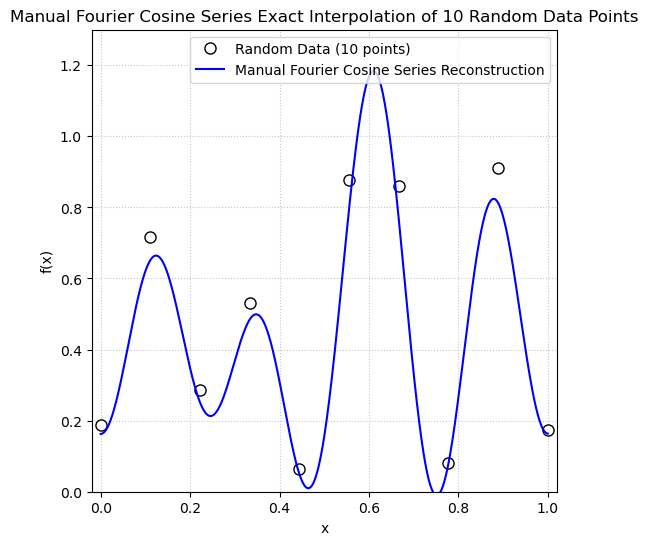

In [65]:
def manual_fourier_cosine_series(y_data, L):
    """
    手动实现傅里叶余弦级数系数计算，基于提供的公式 (9) 和 (10)。
    假设 y_data 是在区间 [0, L] 上 N 个等距采样点的值，包括 f(0) 和 f(L)。
    即，y_data[k_idx] 对应 f(k_idx * L / (N-1))。

    参数:
    y_data (numpy.ndarray): 离散采样点的函数值数组。
    L (float): 傅里叶级数所在的区间长度 [0, L]。

    返回:
    tuple: (a0, an_coeffs)
        a0 (float): 傅里叶级数的直流分量 (n=0)。
        an_coeffs (numpy.ndarray): 傅里叶级数的余弦系数数组，从 a1 到 a_{N-1}。
    """
    N = len(y_data) # 数据点的数量，对应公式中的 N

    if N < 2:
        raise ValueError("需要至少两个数据点来计算傅里叶余弦级数。")

    # --- 计算 a0 (方程 9) ---
    # f(0) 对应 y_data 中的第一个点
    f0 = y_data[0]
    # f(L) 对应 y_data 中的最后一个点
    fL = y_data[N-1]

    sum_a0 = 0.0
    # 公式中的求和项 sum_{k=1}^{N-1} f(k/N)
    # 鉴于我们的数据点是 x_k = k * L / (N-1)，且 f(0) 和 f(L) 已单独处理，
    # 这里的求和对应 y_data[1] 到 y_data[N-2] (即中间的 N-2 个点)。
    for k_idx in range(1, N - 1): # 遍历内部点 (从索引 1 到 N-2)
        sum_a0 += y_data[k_idx]
    
    # 根据公式 (9) 计算 a0
    a0 = (1 / N) * ((f0 + fL) / 2 + sum_a0)
    
    # --- 计算 an (方程 10) ---
    # an_coeffs 将存储 a1, a2, ..., a_{N-1}
    # 使用 np.zeros(N) 是为了方便索引，an_coeffs[n] 对应 a_n。
    # 实际返回时我们会切片，只返回 a1 到 a_{N-1}。
    an_coeffs = np.zeros(N) 

    # n 从 1 到 N-1
    for n in range(1, N): 
        sum_an = 0.0
        # 公式中的余弦项 cos(n*pi*k/N)
        # 如果我们的数据点是 x_k = k_idx * L / (N-1)，那么 x_k/L = k_idx / (N-1)
        # 所以这里的余弦参数变为 n * pi * k_idx / (N - 1)
        for k_idx in range(1, N - 1): # 遍历内部点 (从索引 1 到 N-2)
            sum_an += y_data[k_idx] * np.cos(n * np.pi * k_idx / (N - 1))
        
        # 计算公式 (10) 中的第一项
        term1_an = (f0 + fL * np.cos(n * np.pi)) / 2
        
        # 根据公式 (10) 计算 a_n
        an_coeffs[n] = (2 / N) * (term1_an + sum_an)
        
    # 返回 a0 和 a_n 从 a1 开始的系数数组
    return a0, an_coeffs[1:] 

def reconstruct_manual_fourier_series(x_eval, a0, an_coeffs, L):
    """
    使用手动计算的傅里叶余弦系数重建函数，基于提供的公式 (8)。

    参数:
    x_eval (numpy.ndarray): 用于重建函数的值的 x 坐标数组。
    a0 (float): 傅里叶级数的直流分量。
    an_coeffs (numpy.ndarray): 傅里叶级数的余弦系数数组 (从 a1 开始)。
    L (float): 傅里叶级数所在的区间长度 [0, L]。

    返回:
    numpy.ndarray: 在 x_eval 处重建的函数值。
    """
    # 初始化重建函数为 a0
    reconstructed_f = np.full_like(x_eval, a0)
    
    # 遍历 an_coeffs (它包含了 a1 到 a_{N-1})
    # len(an_coeffs) 给出有多少个 an 系数 (即 N-1 个)
    for n in range(1, len(an_coeffs) + 1): # n 从 1 到 N-1
        # an_coeffs[n-1] 对应公式中的 a_n
        reconstructed_f += an_coeffs[n-1] * np.cos(n * np.pi * x_eval / L)
        
    return reconstructed_f

# --- 主程序部分 ---

# 1. 生成随机采样数据点
N_samples = 10 # 离散数据点的数量，这对应公式中的 N
L_interval = 1.0 # 傅里叶级数所在的区间长度，即 [0, 1]
# 生成等距的 x 坐标，包括 0 和 L_interval
x_discrete = np.linspace(0, L_interval, N_samples) 
np.random.seed(12) # 为了结果可复现，设置随机种子
# 生成模拟的随机 y 值
y_random_data = np.random.rand(N_samples) * 0.9 + 0.05 

print("生成的离散数据点:")
for i in range(N_samples):
    print(f"x={x_discrete[i]:.2f}, y={y_random_data[i]:.4f}")

# 2. 使用手动方法拟合傅里叶级数
a0_manual, an_manual = manual_fourier_cosine_series(y_random_data, L_interval)

print("\n手动拟合得到的傅里叶系数:")
print(f"a0: {a0_manual:.6f}")
print(f"an (a1 到 a{N_samples-1}):")
for i, val in enumerate(an_manual):
    print(f"  a_{i+1}: {val:.6f}")

# 3. 重建傅里叶级数并绘图
# 生成更密集的点用于绘制平滑的重建曲线
x_plot = np.linspace(0, L_interval, 1000) 
fourier_series_reconstruction_manual = reconstruct_manual_fourier_series(x_plot, a0_manual, an_manual, L_interval)

# --- 验证：重建曲线是否通过原始数据点 ---
# 在原始离散点上重建函数，理论上应该与原始 y_random_data 完全一致（由于是插值）
reconstructed_at_original_points_manual = reconstruct_manual_fourier_series(x_discrete, a0_manual, an_manual, L_interval)
error_manual = y_random_data - reconstructed_at_original_points_manual
print(f"\n手动重建值与原始值的最大绝对误差: {np.max(np.abs(error_manual)):.10f}") 
# 这个误差应该非常接近于零，表明精确插值

# 绘图
plt.figure(figsize=(6, 6))
# 绘制原始数据点
plt.plot(x_discrete, y_random_data, 'o', 
         markeredgecolor='black', markerfacecolor='white', markersize=8, 
         label='Random Data (10 points)')
# 绘制手动重建的傅里叶余弦级数曲线
plt.plot(x_plot, fourier_series_reconstruction_manual, '-', 
         color='blue', linewidth=1.5, 
         label='Manual Fourier Cosine Series Reconstruction')

plt.title(f'Manual Fourier Cosine Series Exact Interpolation of {N_samples} Random Data Points')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(0, 1.3) # 调整 Y 轴范围以更好地可视化
plt.xlim(-0.02, L_interval + 0.02) # 调整 X 轴范围
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()